# Training

> Notebook to train deep learning models or ensembles for segmentation of fluorescent labels in microscopy images.

This notebook is optmizied to be executed on [Google Colab](https://colab.research.google.com).

* If youre new on _Google Colab_, try out the [tutorial](https://colab.research.google.com/notebooks/intro.ipynb).
* Use Firefox or Google Chrome if you want to upload and download files

In [ ]:
#@title Set up environment
#@markdown Please run this cell to get started.
%load_ext autoreload
%autoreload 2
try:
    from google.colab import files, drive
except ImportError:
    pass
try:
    import deepflash2
except ImportError:
    !pip install -q deepflash2
import zipfile
import shutil
import imageio
from sklearn.model_selection import KFold, train_test_split
from fastai.vision.all import *
from deepflash2.all import *
from deepflash2.data import _read_msk
from scipy.stats import entropy

## Provide Training Data

__Required data structure__

- __One folder for training images__
- __One folder for segmentation masks__
    - We highly recommend using [ground truth estimation](https://matjesg.github.io/deepflash2/gt_estimation.html)

_Examplary structure: see [naming conventions](https://matjesg.github.io/deepflash2/add_information.html#Naming)_

* [folder] images
  * [file] 0001.tif
  * [file] 0002.tif
* [folder] masks
  * [file] 0001_mask.png
  * [file] 0002_mask.png

### Option A: Upload via _Google Drive_ (recommended, Colab only)

- The folder in your drive must contain all files and correct folder structure. 
- See [here](https://support.google.com/drive/answer/2375091?co=GENIE.Platform%3DDesktop&hl=en) how to organize your files in _Google Drive_.
- See this [stackoverflow post](https://stackoverflow.com/questions/46986398/import-data-into-google-colaboratory) for browsing files with the file browser

In [ ]:
#@markdown Provide the path to the folder on your _Google Drive_
try:
    drive.mount('/content/drive')
    path = "/content/drive/My Drive/data" #@param {type:"string"}
    path = Path(path)
    print('Path contains the following files and folders: \n', L(os.listdir(path)))
    #@markdown Follow the instructions and press Enter after copying and pasting the key.
except:
    print("Warning: Connecting to Google Drive only works on Google Colab.")
    pass

### Option B: Upload via _zip_ file (Colab only)

- The *zip* file must contain all images and segmentations and correct folder structure. 
- See [here](https://www.hellotech.com/guide/for/how-to-zip-a-file-mac-windows-pc) how to _zip_ files on Windows or Mac.

In [ ]:
#@markdown Run to upload a *zip* file
path = Path('data')
try:
    u_dict = files.upload()
    for key in u_dict.keys():
        unzip(path, key)
    print('Path contains the following files and folders: \n', L(os.listdir(path)))
except:
    print("Warning: File upload only works on Google Colab.")
    pass

### Option C: Provide path (Local installation)

If you're working on your local machine or server, provide a path to the correct folder.

In [ ]:
#@markdown Provide path (either relative to notebook or absolute) and run cell
path = "" #@param {type:"string"}
path = Path(path)
print('Path contains the following files and folders: \n', L(os.listdir(path)))

Path contains the following files and folders: 
 ['expert_segmentations', 'mv_export.zip', 'gt_estimation.ipynb', '.preproc_data', '05_losses.ipynb', 'staple_export.zip', '04_callbacks.ipynb', 'models', '06_utils.ipynb', 'sample_data', 'index.ipynb', 'sample_data_cFOS', 'predict.ipynb', 'add_information.ipynb', '01_models.ipynb', '00_learner.ipynb', '02_data.ipynb', 'model_library.ipynb', '.ipynb_checkpoints', '03_metrics.ipynb', 'docs', '.last_checked', 'sample_data_cFOS.zip', '.gitattributes', 'train.ipynb']


###  Option D: Try with sample data (Testing only)

If you don't have any data available yet, try our sample data

In [ ]:
#@markdown Run to use sample files
path = Path('sample_data_cFOS')
url = "https://github.com/matjesg/deepflash2/releases/download/model_library/wue1_cFOS_small.zip"
urllib.request.urlretrieve(url, 'sample_data_cFOS.zip')
unzip(path, 'sample_data_cFOS.zip')

## Check and load data

In [ ]:
#@markdown Provide your parameters according to your provided data
image_folder = "images" #@param {type:"string"}
mask_folder = "masks" #@param {type:"string"}
mask_suffix = "_mask.png" #@param {type:"string"}
#@markdown Number of classes: e.g., 2 for binary segmentation (foreground and background class)
n_classes = 2 #@param {type:"integer"}
#@markdown Check if you are providing instance labels (class-aware and instance-aware)
instance_labels = False #@param {type:"boolean"}

f_names = get_image_files(path/image_folder)
label_fn = lambda o: path/mask_folder/f'{o.stem}{mask_suffix}'
#Check if corresponding masks exist
mask_check = [os.path.isfile(label_fn(x)) for x in f_names]
if len(f_names)==sum(mask_check) and len(f_names)>0:
    print(f'Found {len(f_names)} images and {sum(mask_check)} masks in "{path}".')
else:
    print(f'IMAGE/MASK MISMATCH! Found {len(f_names)} images and {sum(mask_check)} masks in "{path}".')
    print('Please check the steps above.')

Found 5 images and 5 masks in "sample_data_cFOS".


### Customize [mask weights](https://matjesg.github.io/deepflash2/data.html#Weight-Calculation) (optional)

- Default values should work for most of the data. 
- However, this choice can significantly change the model performance later on.

In [ ]:
#@title { run: "auto" }
#@markdown Run to set weight parameters
border_weight_sigma=10 #@param {type:"slider", min:1, max:20, step:1}
foreground_dist_sigma=10 #@param {type:"slider", min:1, max:20, step:1}
border_weight_factor=10 #@param {type:"slider", min:1, max:50, step:1}
foreground_background_ratio= 0.1 #@param {type:"slider", min:0.1, max:1, step:0.1}

#@markdown Check if want to plot the resulting weights of one mask
plot_weights = False #@param {type:"boolean"}
#@markdown Check `reset_to_defaults` to reset your parameters.
reset_to_defaults = False #@param {type:"boolean"}

mw_dict = {'bws': 10 if reset_to_defaults else border_weight_sigma ,
           'fds': 10 if reset_to_defaults else foreground_dist_sigma, 
           'bwf': 10 if reset_to_defaults else border_weight_factor,
           'fbr' : 0.1 if reset_to_defaults else foreground_background_ratio}

#@markdown Select image number
image_number = 0 #@param {type:"slider", min:0, max:100, step:1}
if plot_weights:
    idx = np.minimum(len(f_names), image_number)
    print('Plotting mask for image', f_names[idx].name, '- Please wait.')
    msk = _read_msk(label_fn(f_names[idx]))
    _, w, _ = calculate_weights(msk, n_dims=n_classes, **mw_dict)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,12))
    axes[0].imshow(msk)
    axes[0].set_axis_off()
    axes[0].set_title('Mask')
    axes[1].imshow(w)
    axes[1].set_axis_off()
    axes[1].set_title('Weights')

### Create mask weights

In [ ]:
#@markdown Run to create mask weights for the whole dataset.
try: 
    mw_dict=mw_dict
except:
    mw_dict = {'bws': 10,'fds': 10, 'bwf': 10,'fbr' : 0.1}

ds = RandomTileDataset(f_names, label_fn, n_classes=n_classes, instance_labels=instance_labels, **mw_dict)

Using cached mask weights from sample_data_cFOS/masks/.cache


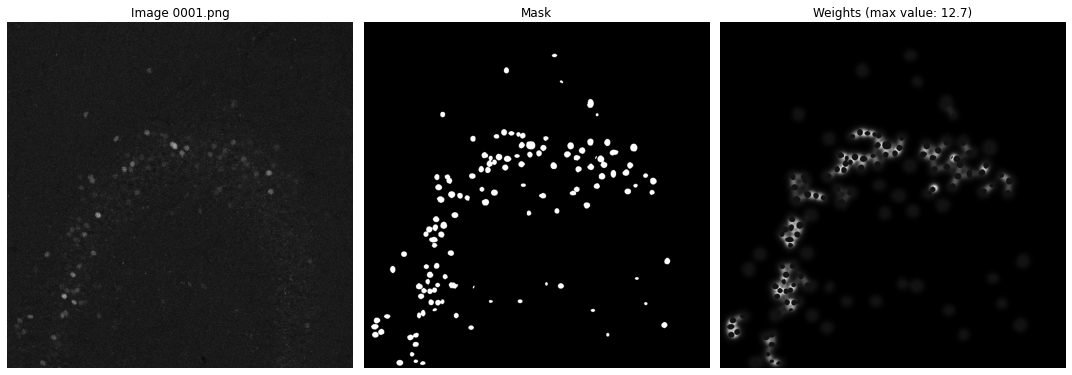

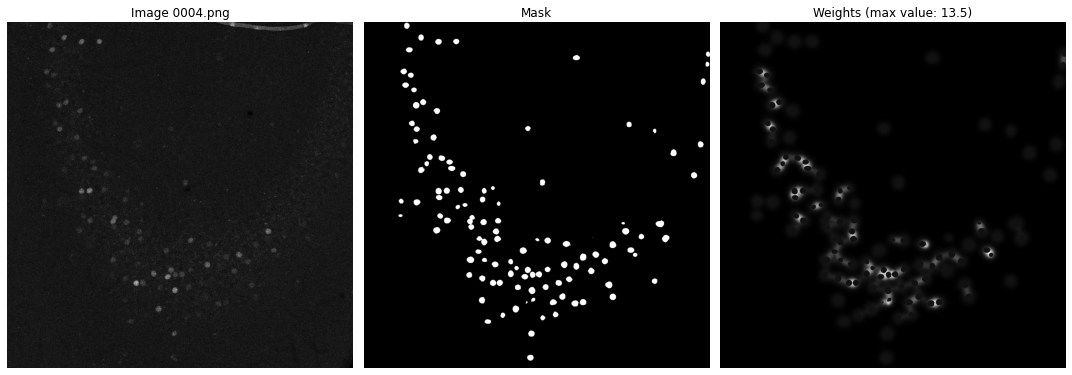

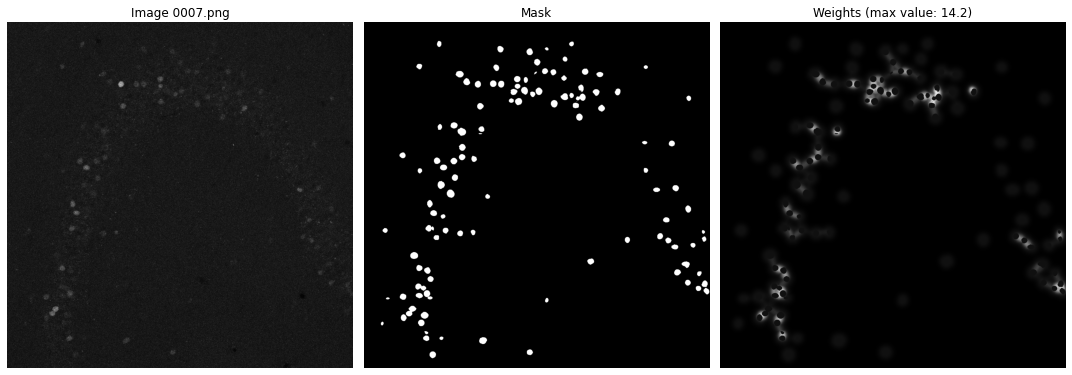

In [ ]:
#@title { run: "auto" }
#@markdown Run to show data.
#@markdown Use the slider to control the number of displayed images
first_n = 3 #@param {type:"slider", min:1, max:100, step:1}
ds.show_data(max_n = first_n, figsize=(15,15), overlay=False)

## Model Defintion

Select one of the available [model architectures](https://matjesg.github.io/deepflash2/models.html#U-Net-architectures).

In [ ]:
#@title { run: "auto" }
model_arch = 'unet_deepflash2' #@param ["unet_deepflash2",  "unet_falk2019", "unet_ronnberger2015"]

Pretrained weights 
- Select 'new' to use an untrained model (no pretrained weights)
- Or select [pretraind](https://matjesg.github.io/deepflash2/model_library.html) model weights from dropdown menu


In [ ]:
pretrained_weights = "wue_cFOS" #@param ["new", "wue_cFOS", "wue_Parv", "wue_GFAP", "wue_GFP", "wue_OPN3"]
pre = False if pretrained_weights=="new" else True
n_channels = ds.get_data(max_n=1)[0].shape[-1]
model = torch.hub.load('matjesg/deepflash2', model_arch, pretrained=pre, dataset=pretrained_weights, n_classes=ds.c, in_channels=n_channels)
if pretrained_weights=="new": apply_init(model)

Using cache found in /media/data/home/mag01ud/.cache/torch/hub/matjesg_deepflash2_master


### Setting model hyperparameters (optional)

- *mixed_precision_training*: enables [Mixed precision training](https://docs.fast.ai/callback.fp16#A-little-bit-of-theory)
    - decreases memory usage and speed-up training
    - may effect model accuracy
- *batch_size*: the number of samples that will be propagated through the network during one iteration
    - 4 works best in our experiements
    - 4-8 works good for [mixed precision training](https://docs.fast.ai/callback.fp16#A-little-bit-of-theory)
    

In [ ]:
mixed_precision_training = False #@param {type:"boolean"}
batch_size = 4 #@param {type:"slider", min:2, max:8, step:2}
cbs = [SaveModelCallback(monitor='iou'), ElasticDeformCallback]
metrics = [Dice_f1(), Iou()]
loss_fn = WeightedSoftmaxCrossEntropy(axis=1)
dls = DataLoaders.from_dsets(ds,ds, bs=batch_size)
if torch.cuda.is_available(): dls.cuda(), model.cuda()
learn = Learner(dls, model, metrics = metrics, wd=0.001, loss_func=loss_fn, cbs=cbs)
if mixed_precision_training: learn.to_fp16()

- `max_lr`: The learning rate controls how quickly or slowly a neural network model learns.
    - We found that a maximum learning rate of 5e-4 (i.e., 0.0005) yielded the best results across experiments.
    - `learning_rate_finder`: Check only if you want use the [Learning Rate Finder](https://matjesg.github.io/deepflash2/add_information.html#Learning-Rate-Finder) on your dataset.
    

In [ ]:
#@markdown Check and run to use learning rate finder
learning_rate_finder = False #@param {type:"boolean"}
if learning_rate_finder:
    lr_min,lr_steep = learn.lr_find()
    print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [ ]:
max_lr = 5e-4 #@param {type:"number"}

## Model Training

### Setting training parameters

- `n_models`: Number of models to train.
    - If you're experimenting with parameters, try only one model first.
    - Depending on the data, ensembles should comprise 3-5 models.
    - _Note: Number of model affects the [Train-validation-split](https://matjesg.github.io/deepflash2/add_information.html#Train-validation-split)._

In [ ]:
#@title { run: "auto" }
try:
    batch_size=batch_size
except:
    batch_size=4
    mixed_precision_training = False
try:
    max_lr=max_lr
except:
    max_lr = 5e-4 

n_models = 1 #@param {type:"slider", min:1, max:5, step:1}
print("Suggested epochs for 1000 iterations:", calc_iterations(len(ds), batch_size, n_models))

Suggested epochs for 1000 iterations: 267


- `epochs`: One epoch is when an entire (augemented) dataset is passed through the model for training.
    - Epochs need to be adusted depending on the size and number of images
    - We found that choosing the number of epochs such that the network parameters are update about 1000 times (iterations) leads to satiesfying results in most cases.

In [ ]:
epochs = 30 #@param {type:"slider", min:1, max:200, step:1}

### Train models

In [ ]:
#@markdown Run to train model(s).<br/> **THIS CAN TAKE A FEW HOURS FOR MULTIPLE MODELS!**
kf = KFold(n_splits=max(n_models,2))
model_path = path/'models'
model_path.mkdir(parents=True, exist_ok=True)
res, res_mc = {}, {}
fold = 0
for train_idx, val_idx in kf.split(f_names):
    fold += 1
    name = f'model{fold}'
    print('Train', name)
    if n_models==1:
        files_train, files_val = train_test_split(f_names)
    else:
        files_train, files_val = f_names[train_idx], f_names[val_idx]
    print(f'Validation Images: {files_val}')    
    train_ds = RandomTileDataset(files_train, label_fn, **mw_dict)
    valid_ds = TileDataset(files_val, label_fn, **mw_dict)
    
    dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=batch_size)
    dls_valid = DataLoaders.from_dsets(valid_ds, batch_size=batch_size ,shuffle=False, drop_last=False)
    model = torch.hub.load('matjesg/deepflash2', model_arch, pretrained=pre, 
                           dataset=pretrained_weights, n_classes=ds.c, in_channels=n_channels)
    if pretrained_weights=="new": apply_init(model)
    if torch.cuda.is_available(): dls.cuda(), model.cuda(), dls_valid.cuda()
        
    learn = Learner(dls, model, metrics = metrics, wd=0.001, loss_func=loss_fn, cbs=cbs)
    if mixed_precision_training: learn.to_fp16()
    learn.fit_one_cycle(epochs, max_lr)
    # save_model(model_path/f'{name}.pth', learn.model, opt=None)
    torch.save(learn.model.state_dict(), model_path/f'{name}.pth', _use_new_zipfile_serialization=False)
    
    smxs, segs, _ = learn.predict_tiles(dl=dls_valid.train)    
    smxs_mc, segs_mc, std = learn.predict_tiles(dl=dls_valid.train, mc_dropout=True, n_times=10)
    
    for i, file in enumerate(files_val):
        res[(name, file)] = smxs[i], segs[i]
        res_mc[(name, file)] = smxs_mc[i], segs_mc[i], std[i]
    
    if n_models==1:
        break

Train model1
Validation Images: [Path('sample_data_cFOS/images/0001.png'), Path('sample_data_cFOS/images/0008.png')]


Using cached mask weights from sample_data_cFOS/masks/.cache


Using cached mask weights from sample_data_cFOS/masks/.cache


Using cache found in /media/data/home/mag01ud/.cache/torch/hub/matjesg_deepflash2_master


epoch,train_loss,valid_loss,dice_f1,iou,time
0,0.055731,0.017789,0.823212,0.699541,00:08
1,0.045225,0.017485,0.820652,0.695852,00:06
2,0.040313,0.017507,0.809525,0.680002,00:06
3,0.046591,0.017985,0.800250,0.667014,00:04
4,0.048958,0.017490,0.814629,0.687236,00:04
5,0.050525,0.017259,0.825245,0.702483,00:04
6,0.054438,0.017365,0.819816,0.694651,00:04
7,0.054848,0.020849,0.783882,0.644578,00:04
8,0.055162,0.018930,0.801864,0.669259,00:04
9,0.054287,0.018495,0.813327,0.685384,00:03


Better model found at epoch 0 with iou value: 0.6995411832178938.
Better model found at epoch 5 with iou value: 0.7024832532647676.


/media/data/anaconda3/envs/fastai/lib/python3.8/site-packages/fastai/learner.py:54: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


## Validate models

Here you can validate your models. To avoid information leakage, only predictions on the respective models' validation set are made.

In [ ]:
#@markdown Create folders to save the resuls. They will be created at your provided 'path'.
pred_dir = 'val_preds' #@param {type:"string"}
pred_path = path/pred_dir/'ensemble'
pred_path.mkdir(parents=True, exist_ok=True)
uncertainty_dir = 'val_uncertainties' #@param {type:"string"}
uncertainty_path = path/uncertainty_dir/'ensemble'
uncertainty_path.mkdir(parents=True, exist_ok=True)
result_path = path/'results'
result_path.mkdir(exist_ok=True)

#@markdown Define `filetype` to save the predictions and uncertainties. All common [file formats](https://imageio.readthedocs.io/en/stable/formats.html) are supported.
filetype = 'png' #@param {type:"string"}

Validating model1


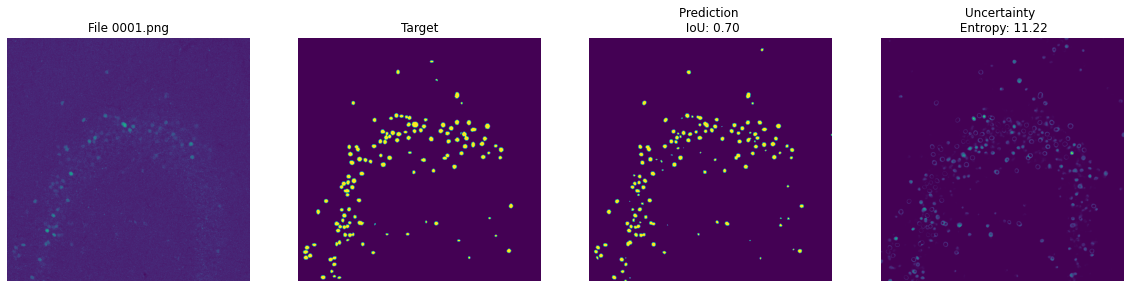

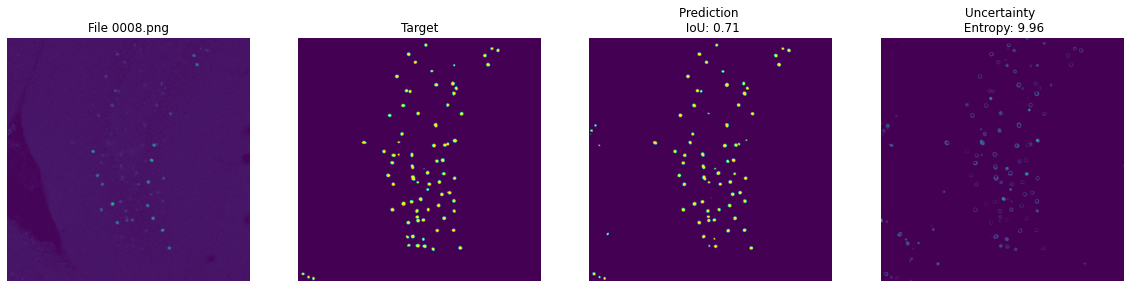

In [ ]:
#@markdown Show and save results
res_list = []
for model_number in range(1,n_models+1):
    model_name = f'model{model_number}'
    val_files = [f for mod , f in res.keys() if mod == model_name]
    print(f'Validating {model_name}')
    pred_path = path/pred_dir/model_name
    pred_path.mkdir(parents=True, exist_ok=True)
    uncertainty_path = path/uncertainty_dir/model_name
    uncertainty_path.mkdir(parents=True, exist_ok=True)
    for file in val_files:
        img = ds.get_data(file)[0]
        msk = ds.get_data(file, mask=True)[0]
        pred = res[(model_name,file)][1]
        pred_std = res_mc[(model_name,file)][2][...,0]
        df_tmp = pd.Series({'file' : file.name,
                            'model' : model_name,
                            'iou': iou(msk, pred),
                            'entropy': entropy(pred_std, axis=None)})
        plot_results(img, msk, pred, pred_std, df=df_tmp)
        res_list.append(df_tmp)
        imageio.imsave(pred_path/f'{file.stem}_pred.{filetype}', pred.astype(np.uint8) if np.max(pred)>1 else pred.astype(np.uint8)*255)
        imageio.imsave(uncertainty_path/f'{file.stem}_uncertainty.{filetype}', pred_std.astype(np.uint8)*255)
df_res = pd.DataFrame(res_list)
df_res.to_csv(result_path/f'val_results.csv', index=False)

## Download Section

- The models will always be the _last_ version trained in section _Model Training_
- To download validation predictions and uncertainties, you first need to execute section _Validate models_.

_Note: If you're connected to *Google Drive*, the models are automatically saved to your drive._

In [ ]:
#@title Download models { run: "auto" }
model_number = "1" #@param ["1", "2", "3", "4", "5"]
model_path = path/'models'/f'model{model_number}.pth'
try:
    files.download(model_path)
except:
    print("Warning: File download only works on Google Colab.")
    print(f"Models are saved at {model_path.parent}")
    pass

Models are saved at sample_data_cFOS/models


In [ ]:
#@markdown Download validation predicitions { run: "auto" }
out_name = 'val_predictions'
shutil.make_archive(path/out_name, 'zip', path/pred_dir)
try:
    files.download(path/f'{out_name}.zip')
except:
    print("Warning: File download only works on Google Colab.")
    pass

In [ ]:
#@markdown Download validation uncertainties
out_name = 'val_uncertainties'
shutil.make_archive(path/out_name, 'zip', path/uncertainty_dir)
try:
    files.download(path/f'{out_name}.zip')
except:
    print("Warning: File download only works on Google Colab.")
    pass

In [ ]:
#@markdown Download result analysis '.csv' files
try:
    files.download(result_path/f'val_results.csv')
except:
    print("Warning: File download only works on Google Colab.")
    pass